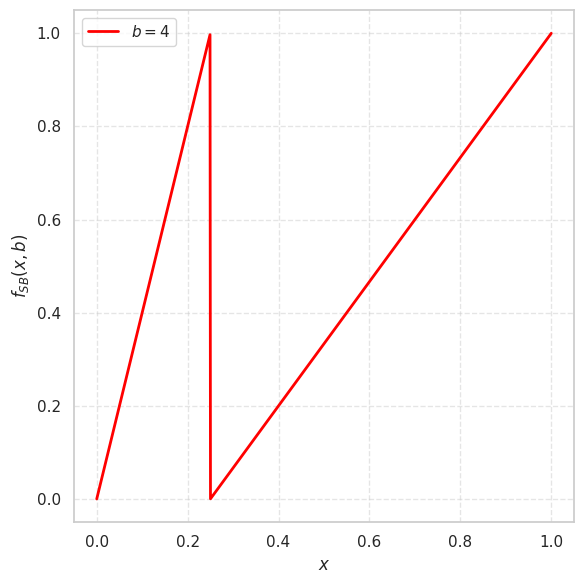

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Mathtext (no external LaTeX) for Colab
plt.rcParams.update({
    "text.usetex": False,  # Colab cannot use LaTeX
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

# Skewed tent map function
def f_SB(x, b):
    return np.where(x <= 1/b, b*x, (b*x - 1)/(b - 1))

# Parameters
b = 4
x = np.linspace(0, 1, 1000)
y = f_SB(x, b)

# Seaborn style
sns.set(style="whitegrid")

# Plot
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x, y, color='red', lw=2, label=f"$b = {b}$")

# Labels and title
ax.set_xlabel("$x$")
ax.set_ylabel("$f_{SB}(x, b)$")
#ax.set_title("Skewed Tent Map")

# Grid and legend
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

# Save figure
plt.tight_layout()
plt.savefig("skewed_tent_map.pdf")  # vector graphic for thesis
plt.show()


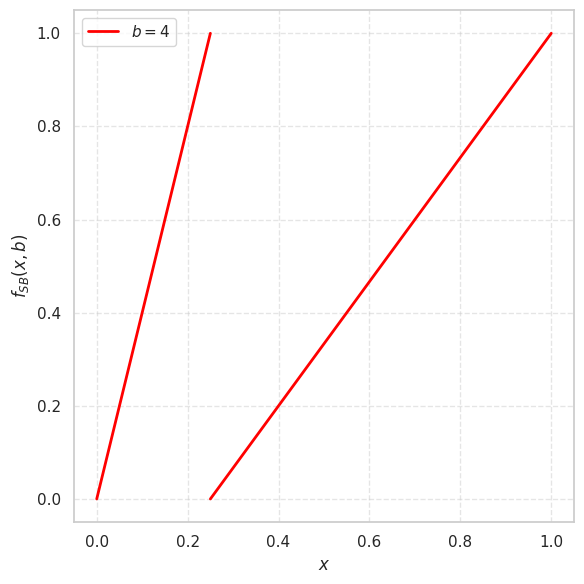

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Mathtext (no external LaTeX) for Colab
plt.rcParams.update({
    "text.usetex": False,  # Colab cannot use LaTeX
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

# Skewed tent map function (two branches)
def f_SB_left(x, b):
    return b * x

def f_SB_right(x, b):
    return (b * x - 1) / (b - 1)

# Parameters
b = 4
x_left = np.linspace(0, 1/b, 500)
x_right = np.linspace(1/b, 1, 500)

y_left = f_SB_left(x_left, b)
y_right = f_SB_right(x_right, b)

# Seaborn style
sns.set(style="whitegrid")

# Plot
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x_left, y_left, color='red', lw=2, label=fr"$b = {b}$")
ax.plot(x_right, y_right, color='red', lw=2)

# Labels
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$f_{SB}(x, b)$")

# Grid and legend
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

# Save figure
plt.tight_layout()
plt.savefig("skewed_tent_map.pdf")  # vector graphic for thesis
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

# Define the skewed Bernoulli map and its derivative
def f_SB(x, b):
    return np.where(x <= 1/b, b * x, (b * x - 1) / (b - 1))

def df_SB(x, b):
    return np.where(x <= 1/b, b, b / (b - 1))

In [ ]:
def evolve_system(y, v, epsilon, b):
    N = len(y)
    y_mean = np.mean(y)
    input_y = (1 - epsilon) * y + epsilon * y_mean
    y_next = f_SB(input_y, b)

    v_mean = np.mean(v)
    input_v = (1 - epsilon) * v + epsilon * v_mean
    f_prime = df_SB(input_y, b)
    v_next = f_prime * input_v

    return y_next, v_next

def compute_lyapunov(N, b=4.0, epsilon=0.02, T_trans=2000, T_lyap=10000):
    y = np.random.rand(N).astype(np.float64)
    v = np.random.rand(N).astype(np.float64)
    v /= np.linalg.norm(v)

    # Burn-in period
    for _ in range(T_trans):
        y, v = evolve_system(y, v, epsilon, b)
        v /= np.linalg.norm(v)

    le_sum = 0.0
    for _ in range(T_lyap):
        y, v = evolve_system(y, v, epsilon, b)
        norm_v = np.linalg.norm(v)
        le_sum += np.log(norm_v)
        v /= norm_v

    return le_sum / T_lyap

In [ ]:
def compute_lyapunov_avg(args):
    N, b, epsilon, T_trans, T_lyap, trials = args
    return np.mean([
        compute_lyapunov(N, b, epsilon, T_trans, T_lyap)
        for _ in range(trials)
    ])


In [ ]:
def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from multiprocessing import Pool

# ----- Simulation part -----
def simulate_lyapunov(N_list, b=4.0, epsilon=0.02, trials=5, T_trans=2000, T_lyap=10000):
    args = [(N, b, epsilon, T_trans, T_lyap, trials) for N in N_list]

    with Pool() as pool:
        lambda_list = pool.map(compute_lyapunov_avg, args)

    lambda_array = np.array(lambda_list)
    lambda_inf = np.mean(lambda_array[-3:])  # average of largest 3 N

    return lambda_array, lambda_inf



In [ ]:
# ----- Plotting part -----
def plot_lyapunov(N_list, lambda_array, lambda_inf):
    sns.set(style="whitegrid")

    # Matplotlib aesthetics for thesis
    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 12,
        "axes.labelsize": 14,
        "axes.titlesize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12
    })

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # ----- Plot 1: λ(N) vs 1 / ln(N) -----
    x1 = 1 / np.log(N_list)
    y1 = lambda_array
    coeffs1 = np.polyfit(x1, y1, 1)
    y1_fit = np.polyval(coeffs1, x1)
    r2_1 = r2_score(y1, y1_fit)

    axs[0].plot(x1, y1, 'o', color='red', markersize=8, label='Data')  # blue points
    axs[0].plot(x1, y1_fit, 'b--', lw=2, label='Fit')                    # green dashed fit
    axs[0].set_xlabel('1 / ln(N)')
    axs[0].set_ylabel('λ(N)')
    axs[0].set_title(f'Logarithmic Fit\n$R^2$ = {r2_1:.4f}')
    axs[0].legend()
    axs[0].tick_params(axis='both', which='major', labelsize=12)

    # ----- Plot 2: ln(λ∞ - λ(N)) vs ln(N) -----
    x2 = np.log(N_list)
    delta = np.abs(lambda_inf - lambda_array) + 1e-12
    y2 = np.log(delta)
    coeffs2 = np.polyfit(x2, y2, 1)
    y2_fit = np.polyval(coeffs2, x2)
    r2_2 = r2_score(y2, y2_fit)
    gamma = -coeffs2[0]

    axs[1].plot(x2, y2, 'o', color='red', markersize=8, label='Data')  # blue points
    axs[1].plot(x2, y2_fit, 'b--', lw=2, label='Fit')                    # green dashed fit
    axs[1].set_xlabel('ln(N)')
    axs[1].set_ylabel('ln(λ∞ - λ(N))')
    axs[1].set_title(f'Power-law Fit, γ ≈ {gamma:.2f}\n$R^2$ = {r2_2:.4f}')
    axs[1].legend()
    axs[1].tick_params(axis='both', which='major', labelsize=12)

    filename = f"scaling_plot.pdf"
    plt.savefig(filename, bbox_inches="tight", dpi=300)
    print(f"Plot saved as {filename}")

    plt.tight_layout()
    plt.show()


    return gamma, r2_1, r2_2

In [ ]:
# -------------------------------
# Step 0: Define the list of N values
# -------------------------------
N_list = [400, 800, 1600, 3200, 6400, 12800, 25600, 51200]  # example sizes

# -------------------------------
# Step 1: Run the simulation
# -------------------------------
lambda_array, lambda_inf = simulate_lyapunov(
    N_list,
    b=4.0,          # skew parameter for your map
    epsilon=0.02,   # coupling strength
    trials=5,       # number of trials to average
    T_trans=2000,   # transient iterations
    T_lyap=10000    # iterations for Lyapunov computation
)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Plot saved as scaling_plot.pdf


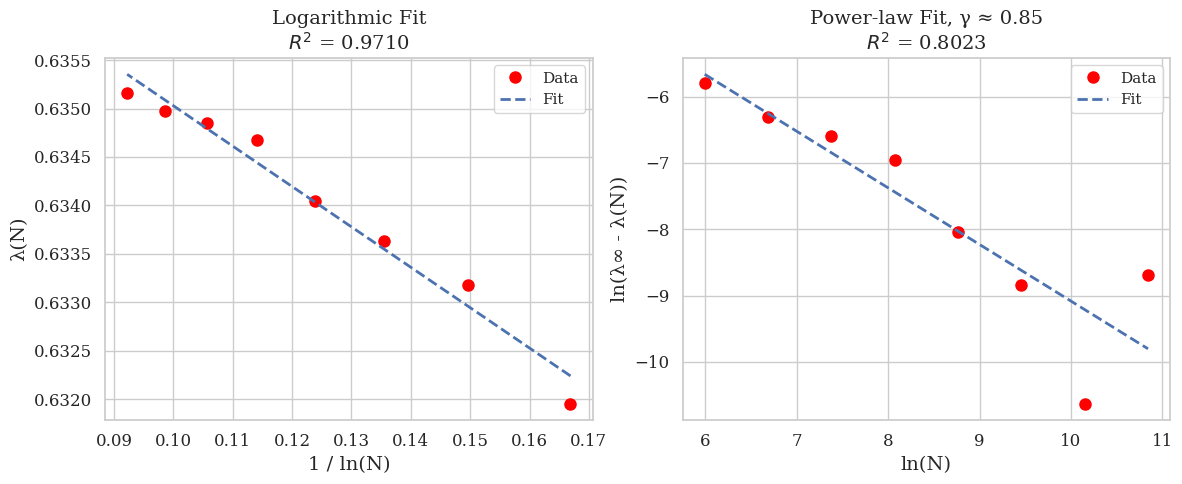

Estimated γ: 0.8532708065445187
R² for logarithmic fit: 0.9710411299864002
R² for power-law fit: 0.8023353175564405


In [ ]:
# -------------------------------
# Step 2: Plot the results
# -------------------------------
gamma, r2_1, r2_2 = plot_lyapunov(
    N_list,
    lambda_array,
    lambda_inf
)

# -------------------------------
# Step 3: Optional print of key results
# -------------------------------
print("Estimated γ:", gamma)
print("R² for logarithmic fit:", r2_1)
print("R² for power-law fit:", r2_2)

Plot saved as run1_plot.pdf


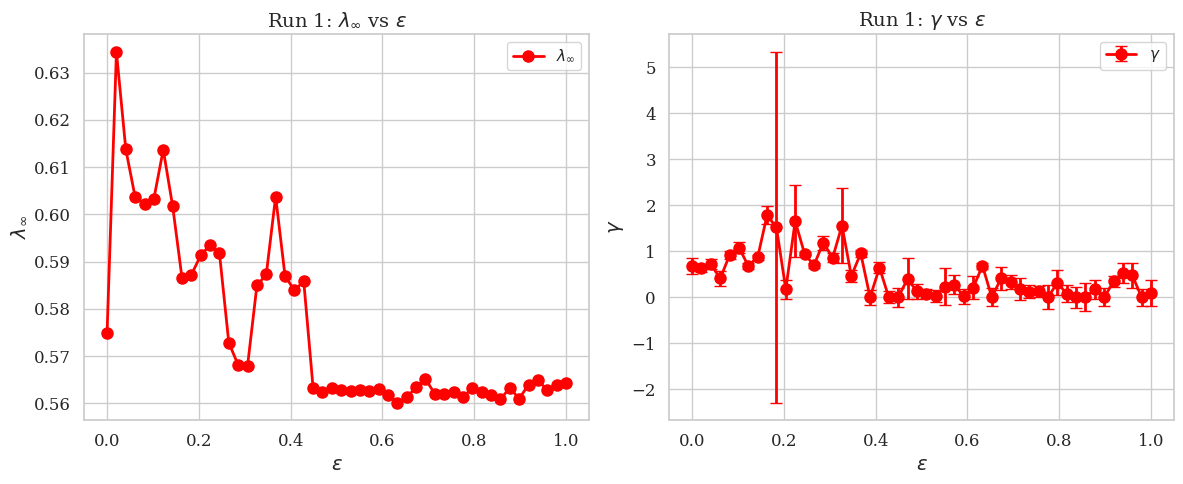

In [ ]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ----- Load data -----
def load_run_data(run_number, base_path="/content/drive/MyDrive/lyapunov_runs"):
    filename = f"run_{run_number}_data.pkl"
    save_path = f"{base_path}/{filename}"
    with open(save_path, "rb") as f:
        eps_arr, lambda_arr, gamma_arr, gamma_err_arr = pickle.load(f)
    return eps_arr, lambda_arr, gamma_arr, gamma_err_arr

# ----- Plotting function -----
def plot_run(eps_arr, lambda_arr, gamma_arr, gamma_err_arr, run_number,
             figsize=(12,5), markersize=8, capsize=4, lw=2):
    sns.set(style="whitegrid")

    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 12,
        "axes.labelsize": 14,
        "axes.titlesize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12
    })

    fig, axs = plt.subplots(1, 2, figsize=figsize)

    # ----- Plot 1: Lambda_inf vs Epsilon -----
    axs[0].plot(eps_arr, lambda_arr, 'o-', color='red',
                markersize=markersize, lw=lw, label=r'$\lambda_{\infty}$')
    axs[0].set_title(f"Run {run_number}: $\\lambda_\\infty$ vs $\\epsilon$")
    axs[0].set_xlabel(r"$\epsilon$")
    axs[0].set_ylabel(r"$\lambda_\infty$")
    axs[0].legend()
    axs[0].tick_params(axis='both', which='major', labelsize=12)

    # ----- Plot 2: Gamma vs Epsilon (with error bars) -----
    axs[1].errorbar(eps_arr, gamma_arr, yerr=gamma_err_arr,
                    fmt='o-', color='red',
                    markersize=markersize, lw=lw, capsize=capsize,
                    label=r'$\gamma$')
    axs[1].set_title(f"Run {run_number}: $\\gamma$ vs $\\epsilon$")
    axs[1].set_xlabel(r"$\epsilon$")
    axs[1].set_ylabel(r"$\gamma$")
    axs[1].legend()
    axs[1].tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()

    # ----- Save as PDF -----
    filename = f"run{run_number}_plot.pdf"
    plt.savefig(filename, bbox_inches="tight", dpi=300)
    print(f"Plot saved as {filename}")

    plt.show()

# ----- Example usage -----
eps_arr, lambda_arr, gamma_arr, gamma_err_arr = load_run_data(run_number=1)

plot_run(eps_arr, lambda_arr, gamma_arr, gamma_err_arr, run_number=1)


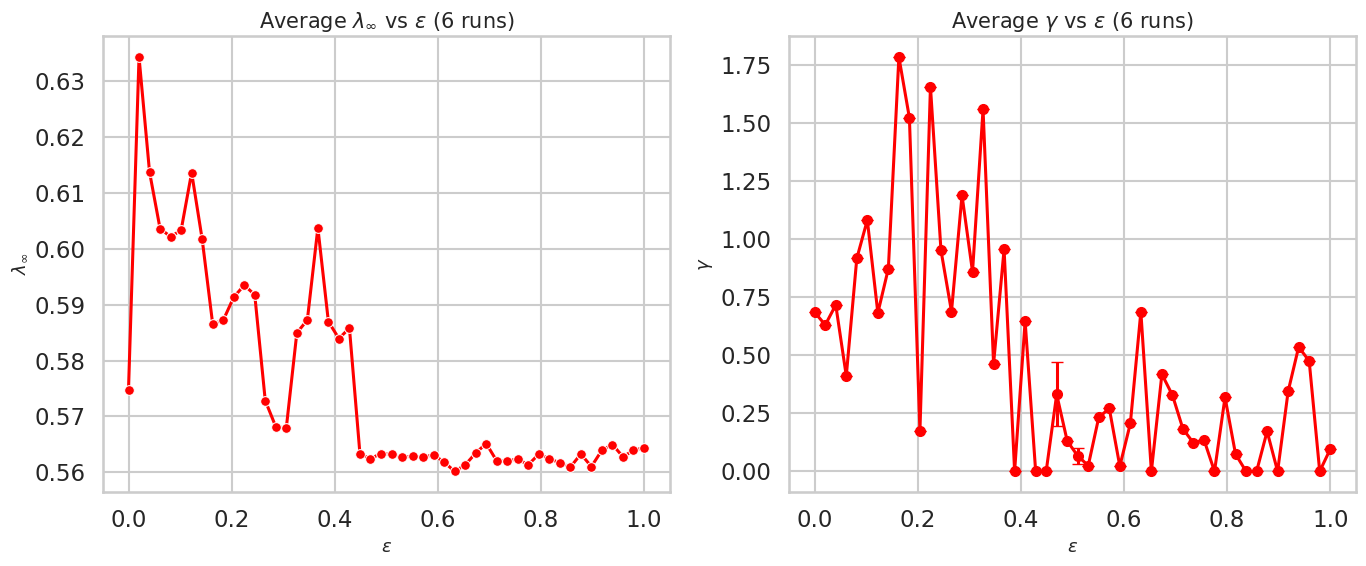

In [ ]:
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Style
sns.set(style="whitegrid", context="talk")

# Load data
files = sorted(glob.glob('/content/drive/MyDrive/lyapunov_runs/run_*_data.pkl'))

all_lambda, all_gamma = [], []

for file in files:
    with open(file, "rb") as f:
        eps_arr, lambda_arr, gamma_arr, gamma_err_arr = pickle.load(f)
        all_lambda.append(lambda_arr)
        all_gamma.append(gamma_arr)

all_lambda = np.array(all_lambda)
all_gamma = np.array(all_gamma)

# Compute averages
lambda_mean = np.nanmean(all_lambda, axis=0)
gamma_mean = np.nanmean(all_gamma, axis=0)
gamma_std = np.nanstd(all_gamma, axis=0)

# Plot
plt.figure(figsize=(14,6))

# Lambda_inf vs Epsilon
plt.subplot(1,2,1)
sns.lineplot(x=eps_arr, y=lambda_mean, marker='o', color ='red', linewidth=2.2, markersize=7)
plt.title("Average $\\lambda_{\\infty}$ vs $\\epsilon$ (6 runs)", fontsize=15)
plt.xlabel("$\\epsilon$", fontsize=13)
plt.ylabel("$\\lambda_{\\infty}$", fontsize=13)

# Gamma vs Epsilon with error bars
plt.subplot(1,2,2)
plt.errorbar(eps_arr, gamma_mean, yerr=gamma_std, marker='o', color = 'red',
             linestyle='-', capsize=4, linewidth=2.2, markersize=7)
plt.title("Average $\\gamma$ vs $\\epsilon$ (6 runs)", fontsize=15)
plt.xlabel("$\\epsilon$", fontsize=13)
plt.ylabel("$\\gamma$", fontsize=13)

plt.tight_layout()

# Save as PDF
plt.savefig("lambda_gamma_vs_epsilon.pdf", format="pdf", bbox_inches="tight")

plt.show()


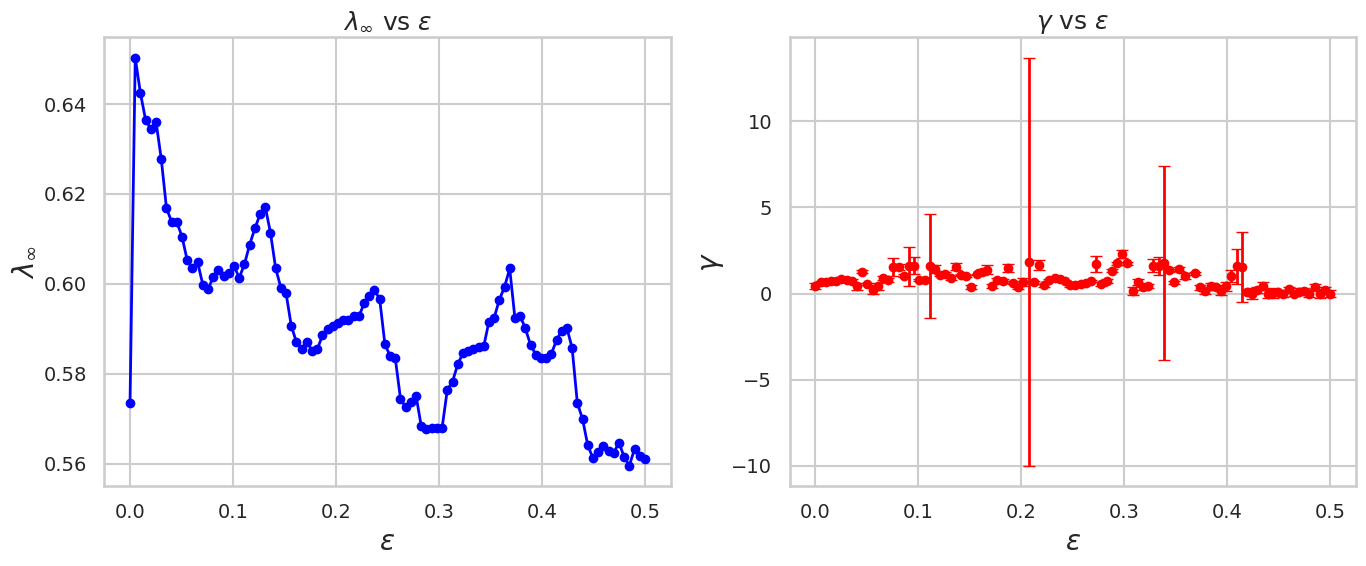

In [ ]:


import pickle
import matplotlib.pyplot as plt

def plot_combined_results(final_file, pdf_filename="combined_results.pdf"):
    # Read the data
    with open(final_file, "rb") as f:
        eps_sorted, lambda_sorted, gamma_sorted, gamma_err_sorted = pickle.load(f)

    # Plot
    plt.figure(figsize=(14,6))

    # Left plot: Lambda_inf vs Epsilon
    plt.subplot(1,2,1)
    plt.plot(eps_sorted, lambda_sorted, marker='o', color='blue', linewidth=2, markersize=6)
    plt.title("$\\lambda_{\\infty}$ vs $\\epsilon$", fontsize=18)
    plt.xlabel("$\\epsilon$", fontsize=20)
    plt.ylabel("$\\lambda_{\\infty}$", fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Right plot: Gamma vs Epsilon
    plt.subplot(1,2,2)
    plt.errorbar(eps_sorted, gamma_sorted, yerr=gamma_err_sorted,
                 fmt='o', color='red', capsize=4, linewidth=2, markersize=6)
    plt.title("$\\gamma$ vs $\\epsilon$", fontsize=18)
    plt.xlabel("$\\epsilon$", fontsize=20)
    plt.ylabel("$\\gamma$", fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.savefig(pdf_filename, format="pdf", bbox_inches="tight")  # Save to PDF
    plt.show()


plot_combined_results("combined_results.pkl")

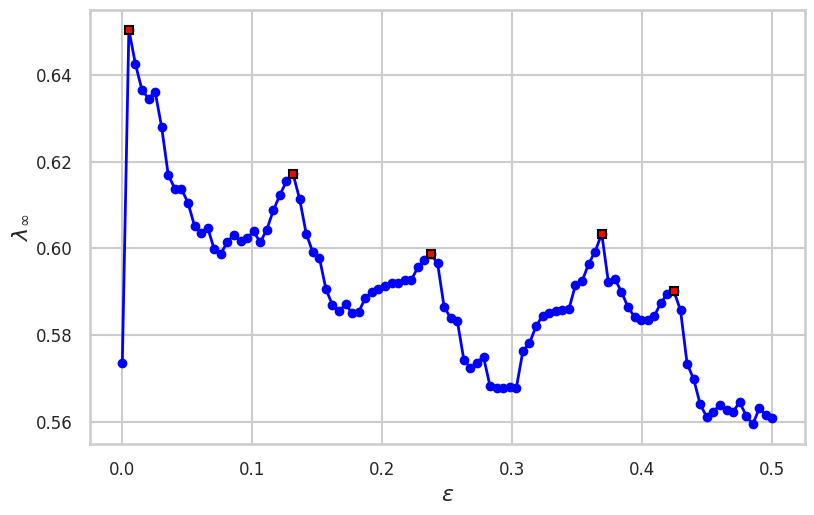

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_lambda_with_special(final_file, epsilon_special,
                             pdf_filename="lambda_vs_epsilon.pdf",
                             line_width=2, marker_size=6, special_marker_size=6):
    # Read the data
    with open(final_file, "rb") as f:
        eps_sorted, lambda_sorted, gamma_sorted, gamma_err_sorted = pickle.load(f)

    eps_sorted = np.array(eps_sorted)
    lambda_sorted = np.array(lambda_sorted)

    # Seaborn whitegrid
    sns.set(style="whitegrid", context="talk")

    # Plot with minimal padding
    fig, ax = plt.subplots(figsize=(8,5))  # smaller figure size

    # Reduce margins around the plot
    plt.subplots_adjust(left=0.12, right=0.95, bottom=0.15, top=0.95)

    # Main curve
    ax.plot(eps_sorted, lambda_sorted, marker='o', color='blue',
            linewidth=line_width, markersize=marker_size)

    # Match nearest lambda values for given epsilon_special
    lambda_special = [lambda_sorted[np.argmin(np.abs(eps_sorted - e))]
                      for e in epsilon_special]

    # Special points (red squares with black edges)
    ax.plot(epsilon_special, lambda_special, 's',
            color='red',
            markeredgecolor='black',
            markeredgewidth=1.5,
            markersize=special_marker_size,
            linewidth=line_width,
            alpha=1)

    # Labels and aesthetics
    ax.set_xlabel("$\\epsilon$", fontsize=16, fontweight="bold")
    ax.set_ylabel("$\\lambda_{\\infty}$", fontsize=16, fontweight="bold")
    ax.tick_params(axis='both', which='major', labelsize=12, width=1.5)

    # Set tight layout with minimal padding
    plt.tight_layout(pad=0.1)

    # Save with minimal whitespace
    plt.savefig(pdf_filename, format="pdf", bbox_inches="tight", pad_inches=0.05)
    plt.show()


# Example usage
epsilon_special = [0.0050, 0.1313, 0.2373, 0.3686, 0.4242]
plot_lambda_with_special("combined_results.pkl", epsilon_special)

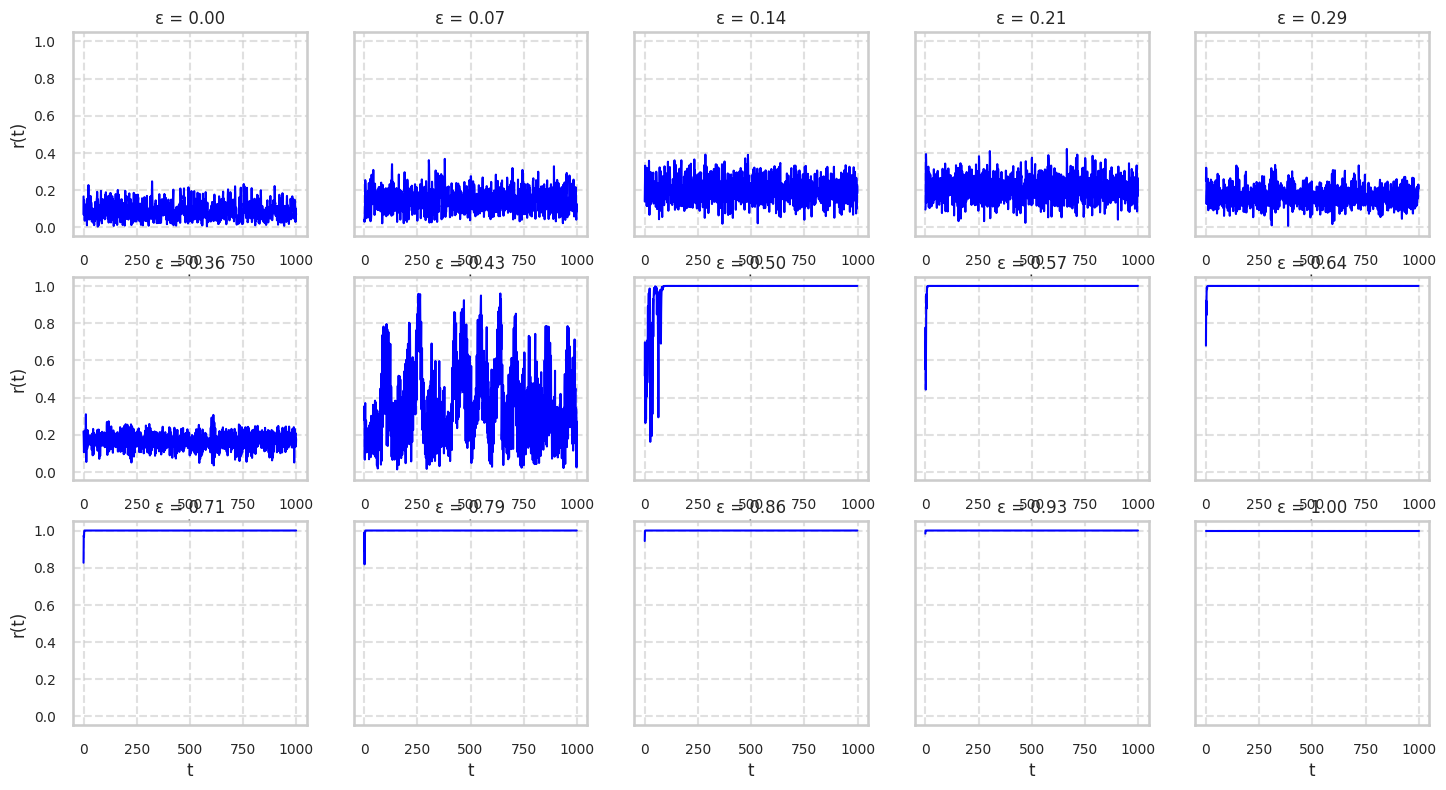

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the academic aesthetic
sns.set(style="whitegrid", context="talk")  # larger fonts, clean grid

def sweep_synchrony_aesthetic(epsilon_list, N=100, T=1000, b=4.0, pdf_filename="synchrony_sweep1.pdf"):

    num_eps = len(epsilon_list)
    ncols = 5
    nrows = int(np.ceil(num_eps / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3.5, nrows*3), sharey=True)
    axes = axes.flatten()

    for idx, epsilon in enumerate(epsilon_list):
        # simulate trajectories
        y = np.random.rand(N)
        y_history = np.zeros((T, N))
        for t in range(T):
            y_mean = np.mean(y)
            input_y = (1 - epsilon) * y + epsilon * y_mean
            y = f_SB(input_y, b)
            y_history[t] = y

        # compute synchrony r(t)
        r_vals = np.abs(np.mean(np.exp(2j * np.pi * y_history), axis=1))

        # plot
        ax = axes[idx]
        ax.plot(r_vals, color='blue', linewidth=1.5)
        ax.set_title(f"ε = {epsilon:.2f}", fontsize=12)
        ax.set_xlabel("t", fontsize=12)
        if idx % ncols == 0:
            ax.set_ylabel("r(t)", fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.grid(True, linestyle='--', alpha=0.6)

    # remove unused axes
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    #plt.tight_layout()
    #plt.suptitle("Synchrony $r(t)$ over different $\\epsilon$ values", fontsize=18, y=1.02)

    # Save as PDF
    plt.savefig(pdf_filename, format="pdf", bbox_inches="tight", dpi=300)

    plt.show()

# Example usage
epsilon_list = np.linspace(0, 1, 15)
sweep_synchrony_aesthetic(epsilon_list, N=100, T=1000)


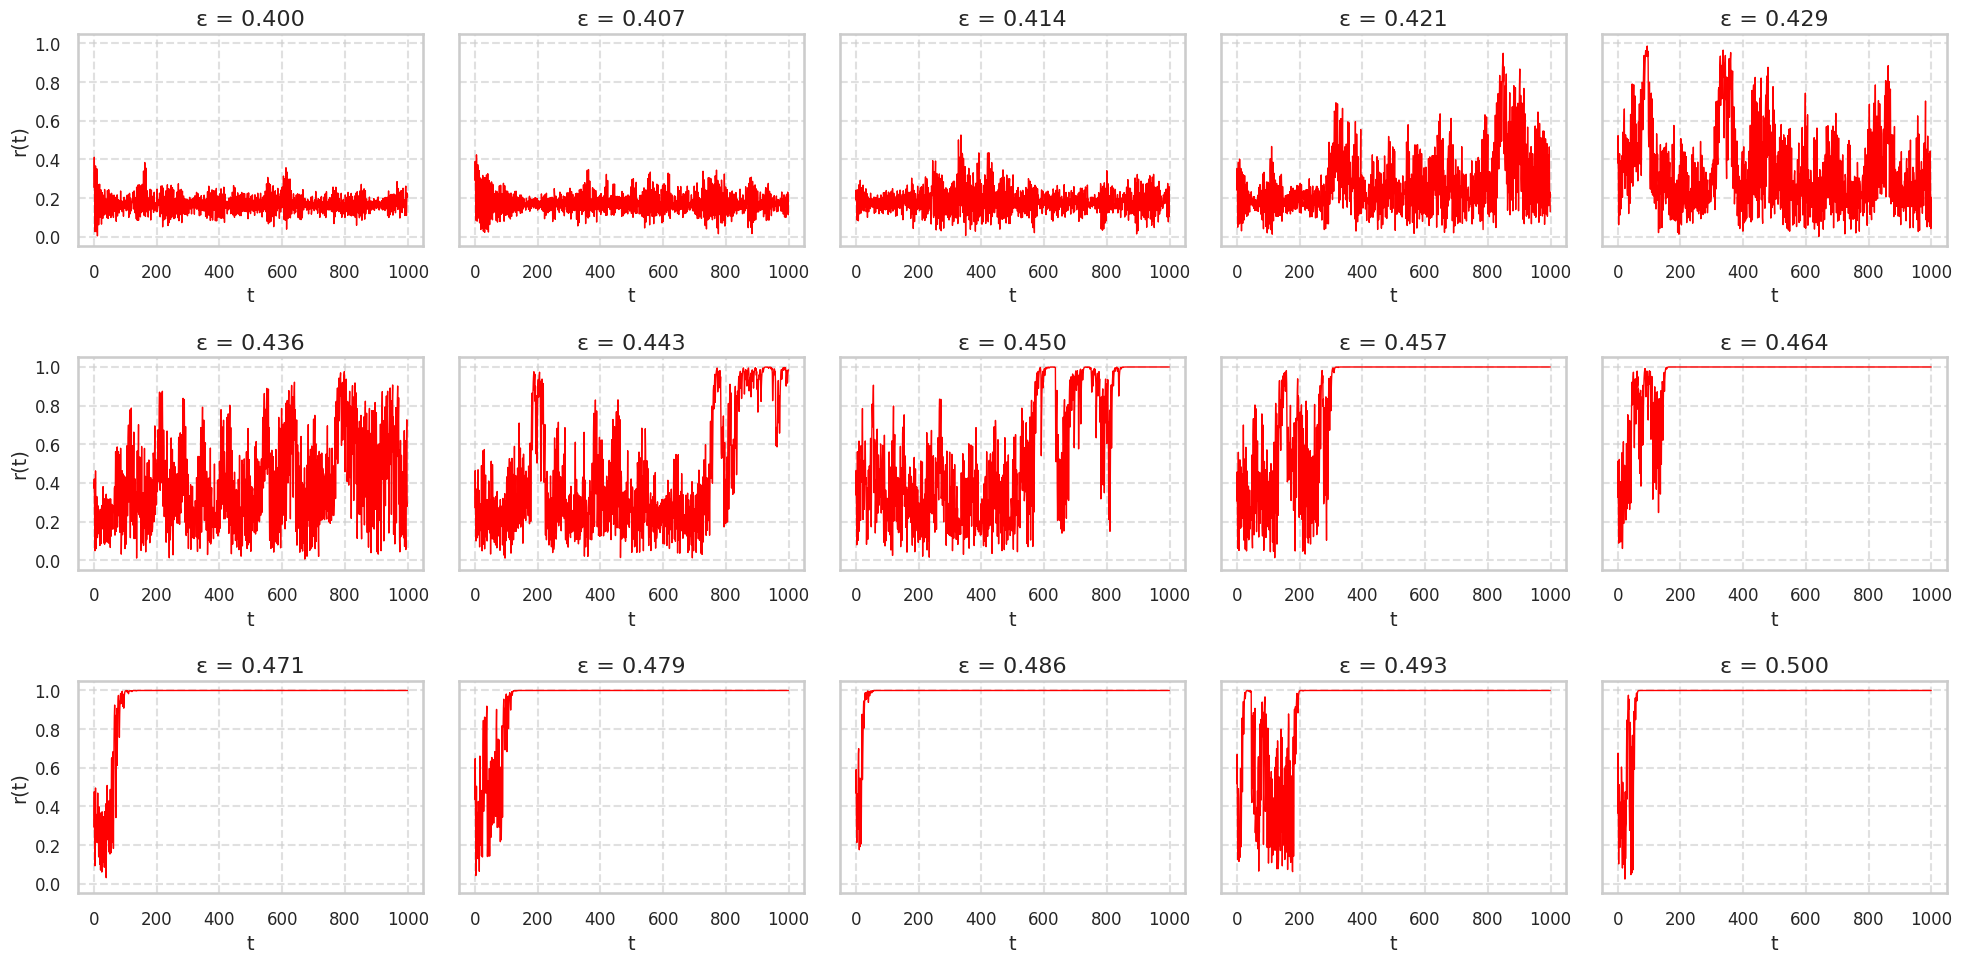

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Academic style
sns.set(style="whitegrid", context="talk")  # larger fonts, clean grid

def sweep_synchrony_aesthetic(epsilon_list, N=100, T=1000, b=4.0, pdf_filename="synchrony_sweep_zoom.pdf"):

    num_eps = len(epsilon_list)
    ncols = 5
    nrows = int(np.ceil(num_eps / ncols))

    # Adjusted figsize to allow for larger labels without overlap
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3.5), sharey=True)
    axes = axes.flatten()

    for idx, epsilon in enumerate(epsilon_list):
        # simulate trajectories
        y = np.random.rand(N)
        y_history = np.zeros((T, N))
        for t in range(T):
            y_mean = np.mean(y)
            input_y = (1 - epsilon) * y + epsilon * y_mean
            y = f_SB(input_y, b)
            y_history[t] = y

        # compute synchrony r(t)
        r_vals = np.abs(np.mean(np.exp(2j * np.pi * y_history), axis=1))

        # plot
        ax = axes[idx]
        ax.plot(r_vals, color='red', linewidth=1)
        ax.set_title(f"ε = {epsilon:.3f}", fontsize=16)
        ax.set_xlabel("t", fontsize=14)
        if idx % ncols == 0:
            ax.set_ylabel("r(t)", fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)

    # remove unused axes
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    #plt.suptitle("Synchrony $r(t)$ over different $\\epsilon$ values", fontsize=20, y=1.02)

    # Save as PDF with high DPI
    plt.savefig(pdf_filename, format="pdf", bbox_inches="tight", dpi=300)

    plt.show()

# Example usage
epsilon_list = np.linspace(0.4, 0.5, 15)
sweep_synchrony_aesthetic(epsilon_list, N=100, T=1000)
